## Introduction
This homework is programming based, where you must use Python to explore the fitting and generalization of regression models via simulation.  
Suppose that $Y$ and $Y$ are both real valued random variables, where $X$ takes value in $(0, 1)$ and $Y$ depends on $X$ according to

>$$Y = cos(2 \pi X) + Z ..................... (1)$$  

where $Z$ is a zero mean Gaussian random variable with variance $\sigma$, and $Z$ is independent of $X$. But assume
that you do not know this dependency of $Y$ on $X$ and that you only observe a sample of $N (X, Y)$ pairs.
Based on the observed sample, you must learn a polynomial regression model and examine the fitting and
generalization capability of your model in relation to the model complexity and sample size.  
Below detailed instructions are given to guide you through this exercise. These instructions only serve as a guideline, which your implementation need not to rigorously follow. You must use Python to write your code. It is fine and encouraged, but NOT compulsory, if you use a Python package that does automatic differentiation. But you must implement manually gradient-based optimization. That is, the
use of the package is only for you to compute the required gradients and you must manually code up the update of model parameters. You need to submit the following deliverables.  
* All Python code
* A concise report explaining your findings.

In [10]:
import torch
import tensorflow as tf
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns

We need DCG_node to check all attributes

In [11]:
def DCG_node(listValue):
    for (i, v) in enumerate(listValue):
        print(f"{i}.data: {v.data}\n{i}.requires_grad: {v.requires_grad}\n{i}.grad: {v.grad}\n{i}.grad_fn: {v.grad_fn}\n{i}.is_leaf: {v.is_leaf}\n")

## getData

Write a function **getData** that generates a dataset ${(x_i, y_i) : i = 1, 2, ... N}$ g of $N (X, Y)$ pairs for a given value of $N$ and $\sigma$. The $X$ values are drawn uniformly at random from $(0, 1)$ and the corresponding $Y$ values are generated according to (1).  
The dataset created by **getData** will then be used to fit your regression models. Of course, in the design of your regression model, you should assume no knowledge on how the dataset is generated.  
The regression models we consider will be exclusively polynomial models, namely, predicts $Y$ from $X$ according to
$$Y = a_0 + a_1X + a_2X^2 + ... + a_dX^d$$
where $d$ is the polynomial degree and $a_i$'s are coefficients to be estimated.

In [87]:
def getData(N: int, sigma: float, plot = False):
    X = torch.empty(N,).uniform_(0, 1).type(torch.FloatTensor)
    f = torch.cos(2 * np.pi * X)
    Z = torch.normal(0, sigma ** 2, size=(N,))
    Y = f + Z
    if plot:
        fig, ax = plt.subplots()
        sns.lineplot(x=X, y=f, color='red', label = 'f(x)', ax=ax)
        sns.scatterplot(x=X, y=Y, color='blue', label='training data', ax=ax);
        plt.title("getData")
    return [(xi, yi) for (xi, yi) in zip(X, Y)]

(500, 2)

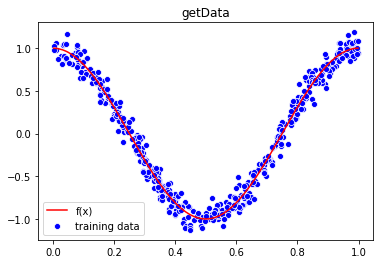

In [93]:
np.shape(getData(500, 0.3, plot=True))

## getMSE

Write a function **getMSE** which computes the mean square error (MSE) for a given dataset fitted to a specified polynomial.

In [71]:
# MSE = (1/N) sum ((Y - (1, x, x ^ 2, ... x ^ d) * A) ^ 2)
# A.size() = (d + 1, 1)
# x.size() = (N, 1)
# Y_real.size() = (N, 1)
def getMSE(Y_real, x, A, y_pred=False):
    if A.grad != None:
        A.grad.data.zeros_()
    A.requires_grad = True
    D = A.size()[0] - 1
    N = x.size()[0]
    X = torch.cat(([(x ** i).view(N, 1) for i in range(D+1)]), dim=1)
    Y_pred = torch.matmul(X, A)
    # print(f"in getMSE: X is {X.size()}, A is {A.size()}, Y_pred is {Y_pred.size()}")
    if y_pred:
        return ((1 / N) * torch.sum((Y_real - Y_pred) ** 2), Y_pred)
    else:
        return (1 / N) * torch.sum((Y_real - Y_pred) ** 2)

In [72]:
# test it the result should be [1.5, 2.5, 6.5]
x = torch.FloatTensor([0, 1, 2, 3])
Y_real = torch.FloatTensor([0, 2, 4, 9])
A = torch.tensor([1.0, 0, 1.0])
L = getMSE(Y_real, x, A)
L.backward()
print(DCG_node([Y_real, x, A, L]))


0.data: tensor([0., 2., 4., 9.])
0.requires_grad: False
0.grad: None
0.grad_fn: None
0.is_leaf: True

1.data: tensor([0., 1., 2., 3.])
1.requires_grad: False
1.grad: None
1.grad_fn: None
1.is_leaf: True

2.data: tensor([1., 0., 1.])
2.requires_grad: True
2.grad: tensor([1.5000, 2.5000, 6.5000])
2.grad_fn: None
2.is_leaf: True

3.data: 0.75
3.requires_grad: True
3.grad: None
3.grad_fn: <MulBackward0 object at 0x7f203851c630>
3.is_leaf: False

None


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  This is separate from the ipykernel package so we can avoid doing imports until


## fitData

Write a function **fitData** that estimates the polynomial coefficients by fitting a given dataset to a degree-d polynomial. The function returns the following:  
1. The estimated polynomial coefficients. The estimation of the coefficients should be based on GD/ SGD /mini-batched SGD.  
**To achieve mini-batched SGD, just select a batch of samples and use several batches in one epoch；in each batch, calculate MSE for selected samples and do backward().**  
**To achieve SGD, just pick up one random sample and calculate MSE then do backward()**
2. The MSE of the dataset fitted to the estimated polynomial. This MSE will be denoted by $E_{in}$.
3. $E_{out}$. To obtain this value, your function needs to generate a separate large testing dataset (say,
containing 1000 or 2000 data points) using **getData** and under the same setting of $\sigma$ and compute
the MSE of the testing dataset fitted to the estimated polynomial.
The computation of $E_{in}$ and $E_{out}$ calls **getMSE**.

### fitData_DG


In [134]:
def fitData_DG(Y_real, x, A, 
               epochs=3000, 
               r=0.001,  
               plot=True, 
               N_test=2000, 
               sigma=0.1):
    LList = []
    epochList = []
    epoch = 0
    D = A.size()[0] - 1 # get Dimension of data, degree-d
    N = x.size()[0] # get number of sample
    L = getMSE(Y_real, x, A.detach_())
    print(f"fitData is DG")
    while epoch < epochs:
        L.backward()
        A = (A - r * A.grad.data).detach() # make A a leaf node
        L = getMSE(Y_real, x, A)
        LList.append(L.item())
        epochList.append(epoch)
        epoch += 1

    # get E_out
    testdata = getData(N_test, sigma, plot=False)
    x = torch.FloatTensor([xi for (xi, yi) in testdata])
    y = torch.FloatTensor([yi for (xi, yi) in testdata])
    (E_out, y_pred) = getMSE(y, x, A.detach_(), y_pred=True)
    y_pred.detach_()

    if plot:
        fig, ax = plt.subplots()
        sns.lineplot(x=epochList, y=LList, color='blue', label = 'MSE', ax=ax)
        plt.title(f"MSE E_in = {L}")
        fig, ax = plt.subplots()
        sns.scatterplot(x=x, y=y, color='blue', label='test dataset', ax=ax)
        sns.lineplot(x=x, y=y_pred, color='red', label='predict line', ax=ax)
        plt.title(f"test data E_out = {E_out}")
    return (A, L, E_out)

fitData is DG
time cost is 3.6834399700164795


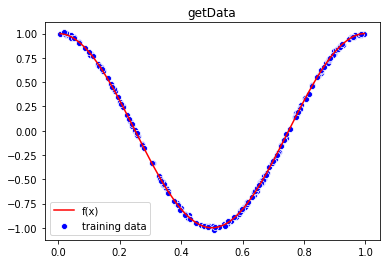

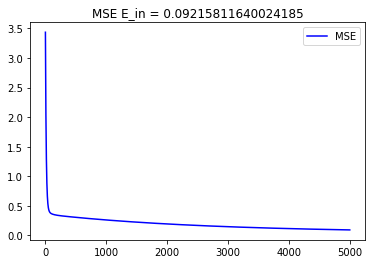

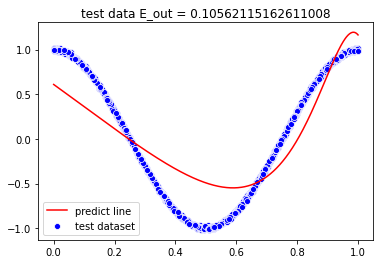

In [139]:
# test fitData_DG
import time
sigma = 0.1
N = 200
N_test = 2000
D = 20
data = getData(N, sigma, plot=True)
x = torch.FloatTensor([xi for (xi, yi) in data])
y = torch.FloatTensor([yi for (xi, yi) in data])
A = torch.rand(D+1)
startTime = time.time()
(A, E_in, E_out) = fitData_DG(y, x, A, epochs = 5000, N_test=N_test, r = 0.01, sigma=sigma)
endTime = time.time()
print(f"time cost is {endTime - startTime}")

### fitData_SDG

In [140]:
def fitData_SDG(Y_real, x, A, 
                 epochs=3000, 
                 r=0.001,
                 plot=True, 
                 N_test=2000, 
                 sigma=0.1):
    LList = []
    epochList = []
    epoch = 0
    D = A.size()[0] - 1 # get Dimension of data
    N = x.size()[0] # get number of sample
    L = getMSE(Y_real, x, A)
    print(f"fitData is SDG")
    while epoch < epochs:
        pickup = rd.randint(0, N-1)
        xi = torch.tensor([(x[pickup] ** i) for i in range(D+1)])
        dA = -2 * (Y_real[pickup] - torch.matmul(xi, A)) * xi
        # print(f"Y_real is {Y_real[pickup]}\n xi is {xi}\n A is {A}\n dA is {dA}\n")
        A = (A - r * dA).detach()
        L = getMSE(Y_real, x, A)
        LList.append(L.item())
        epochList.append(epoch)
        epoch += 1

    # get E_out
    testdata = getData(N_test, sigma, plot=False)
    x = torch.FloatTensor([xi for (xi, yi) in testdata])
    y = torch.FloatTensor([yi for (xi, yi) in testdata])
    (E_out, y_pred) = getMSE(y, x, A.detach_(), y_pred=True)
    y_pred.detach_()

    if plot:
        fig, ax = plt.subplots()
        sns.lineplot(x=epochList, y=LList, color='blue', label = 'MSE', ax=ax)
        plt.title(f"MSE epoch E_in = {E_in}")
        fig, ax = plt.subplots()
        sns.scatterplot(x=x, y=y, color='blue', label='test dataset', ax=ax)
        sns.lineplot(x=x, y=y_pred, color='red', label='predict line', ax=ax)
        plt.title(f"test data E_out = {E_out}")
    return (A, L, E_out)

fitData is SDG
time cost is 4.421200275421143


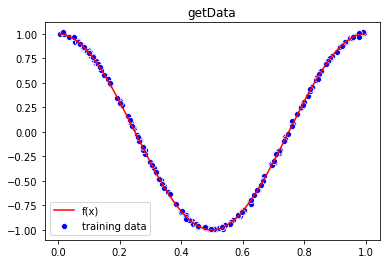

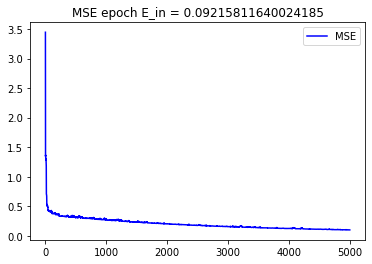

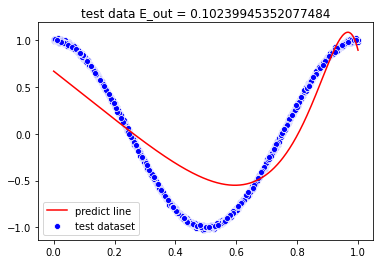

In [141]:
# test fitData_SDG
import time
sigma = 0.1
N = 200
N_test = 2000
D = 20
data = getData(N, sigma, plot=True)
x = torch.FloatTensor([xi for (xi, yi) in data])
y = torch.FloatTensor([yi for (xi, yi) in data])
A = torch.rand(D+1)
startTime = time.time()
(A, E_in, E_out) = fitData_SDG(y, x, A, epochs = 5000, N_test=N_test, r = 0.01, sigma=sigma)
endTime = time.time()
print(f"time cost is {endTime - startTime}")

### fitData_mini

In [142]:
def fitData_mini(Y_real, x, A, 
                 epochs=3000, 
                 r=0.001,  
                 plot=True, 
                 N_test=2000, 
                 batch=200,
                 sigma=0.1):
    LList = []
    epochList = []
    epoch = 0
    D = A.size()[0] - 1 # get Dimension of data
    N = x.size()[0] # get number of all samples
    T = (int)(N / batch)
    print(f"fitdata is mini batch SDG, {T} batch in one epoch")
    while epoch < epochs:
        for t in range(T):
            # print(f"get batch from {t * batch} to {(t+1) * batch}")
            Y_real_in_batch = Y_real[t * batch:(t+1) * batch]
            x_in_batch = x[t * batch: (t+1) * batch]
            L = getMSE(Y_real_in_batch, x_in_batch, A)
            L.backward()
            # DCG_node([A])
            A = (A - r * A.grad.data).detach()
        LList.append(L.item())
        epochList.append(epoch)
        epoch += 1
    
    # get E_out
    testdata = getData(N_test, sigma, plot=False)
    x = torch.FloatTensor([xi for (xi, yi) in testdata])
    y = torch.FloatTensor([yi for (xi, yi) in testdata])
    (E_out, y_pred) = getMSE(y, x, A.detach_(), y_pred=True)
    y_pred.detach_()

    if plot:
        fig, ax = plt.subplots()
        sns.lineplot(x=epochList, y=LList, color='blue', label = 'MSE', ax=ax)
        plt.title(f"MSE epoch E_in = {L}")
        fig, ax = plt.subplots()
        sns.scatterplot(x=x, y=y, color='blue', label='test dataset', ax=ax)
        sns.lineplot(x=x, y=y_pred, color='red', label='predict line', ax=ax)
        plt.title(f"test data E_out = {E_out}")
    return (A, L, E_out)

fitdata is mini batch SDG, 2 batch in one epoch
time cost is 6.030442714691162


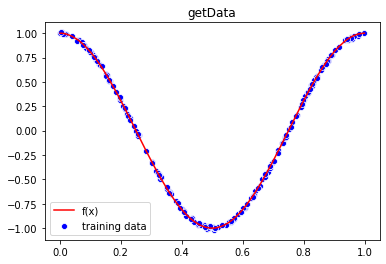

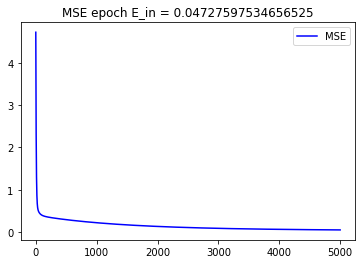

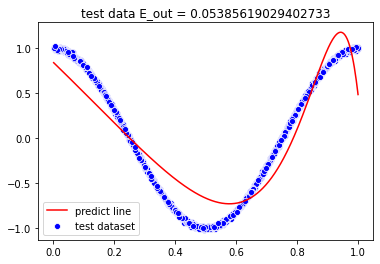

In [143]:
# test fitData_mini
import time
sigma = 0.1
N = 200
N_test = 2000
D = 20
batch=100
data = getData(N, sigma, plot=True)
x = torch.FloatTensor([xi for (xi, yi) in data])
y = torch.FloatTensor([yi for (xi, yi) in data])
A = torch.rand(D+1)
startTime = time.time()
(A, E_in, E_out) = fitData_mini(y, x, A, epochs = 5000, N_test=N_test, r = 0.01, batch=batch, sigma=sigma)
endTime = time.time()
print(f"time cost is {endTime - startTime}")

### fitData

In [144]:
def fitData(Y_real, x, A, 
            epochs=3000, 
            r=0.001,  
            batch=100,
            plot=True, 
            N_test=2000, 
            sigma=0.1,
            mode='dg'):
    if mode == 'DG' or mode == 'dg':
        return fitData_DG(Y_real, x, A, epochs=epochs, r=r,  
                    plot=plot, N_test=N_test, sigma=sigma)
    if mode == 'sdg' or mode == 'SDG':
        return fitData_SDG(Y_real, x, A, epochs=epochs, r=r,  
                    plot=plot, N_test=N_test, sigma=sigma)
    if mode == 'mini':
        return fitData_mini(Y_real, x, A, epochs=epochs, r=r,  
                    plot=plot, N_test=N_test, batch=batch, sigma=sigma)
    

fitdata is mini batch SDG, 4 batch in one epoch
time cost is 10.543828964233398


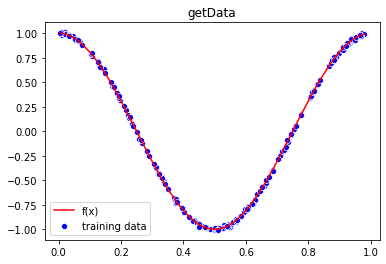

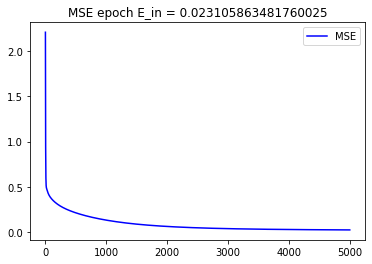

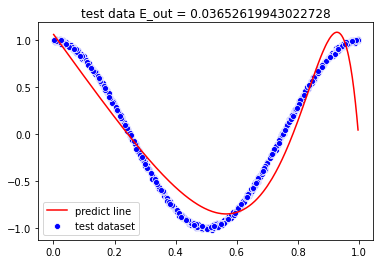

In [145]:
# test fitData_mini
import time
sigma = 0.1
N = 200
N_test = 2000
D = 20
batch=50
N_test = 1000
data = getData(N, sigma, plot=True)
x = torch.FloatTensor([xi for (xi, yi) in data])
y = torch.FloatTensor([yi for (xi, yi) in data])
A = torch.rand(D+1)
startTime = time.time()
(A, E_in, E_out) = fitData(y, x, A, 
                           epochs = 5000, 
                           N_test=N_test, 
                           r = 0.01, 
                           batch=batch, 
                           sigma=sigma,
                           mode='mini')
endTime = time.time()
print(f"time cost is {endTime - startTime}")

## experiment
Write a function **experiment** that takes as input the size $N$ of training dataset, the degree $d$ of the model polynomial and noise variance $\sigma^2$, and does the following. For the given values of $N$, $d$ and $\sigma^2$, it loops over $M$ trials ($M$ not smaller than 20; say, 50 would be a decent number), where each trial is defined
as generating a training dataset of size $N$ and noise variance $\sigma$ (by calling getData) and then fitting the data to a polynomial of degree $d$ (by calling **fitData**). The computed $E_{in}$ and $E_{out}$ are respectively averaged
over the $M$ trials, which are denoted by $\overline{E}_{in}$ and $\overline{E}_{out}$. The obtained $M$ polynomials over the $M$ trials are also averaged. The function then generates another large dataset with noise variance $\sigma^2$ and computes the
average MSE for the dataset fitted to the average polynomial. This MSE will be denoted by $E_{bias}$. The function outputs $\overline{E}_{in}$, $\overline{E}_{out}$ and $E_{bias}$. These three values are the metrics that you will examine.

push to github